Tive que utilizar a transferência de aprendizado do modelo **EfficientNetB0**, pois apresenta um tamanho menor que 100MB, isso é útil para enviar para o Github, de modo que o Heroku consiga acessar.

Veja na tabela: https://keras.io/api/applications/

### Etapa 1 - Importar bibliotecas

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile
tf.__version__

'2.4.1'

### Etapa 2 - Transfer Learning e Reuso do Modelo

# EfficientNetB0

In [2]:
base_model = tf.keras.applications.EfficientNetB0(
    weights = 'imagenet',
    include_top = False,# Para não carrega as camadas
    # somente as convolutions Layers
    # (que apresentam características GERAIS)... pois nós iremos treinar a nossa.   
)

In [3]:
base_model.summary()
# Perceba que ele não invocou a última camada 
# DENSA

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [4]:
# Só para pegar o OUTPUT
x = base_model.output
x

<KerasTensor: shape=(None, None, None, 1280) dtype=float32 (created by layer 'top_activation')>

In [5]:
# Global Average Pooling 2D -> Em vez de usar o 
# MAxpooling (pega o maior), você pega a média

x = tf.keras.layers.GlobalAveragePooling2D()(x)
# OBS: Estamos usando uma sintaxe diferente de
# quando trabalhavamos com modelo SEQUENCIAL... agora
# o (x) fica do lado de fora com parenteses...
# assim que fazemos as ligações neste caso

In [6]:
# Camada 1 (base_model)
x = tf.keras.layers.Dense(units = 1024,
                         activation='relu'
                         )(x)
x = tf.keras.layers.Dense(units = 512,
                         activation='relu'
                         )(x)
# Camada 2 (preds)
preds = tf.keras.layers.Dense(units = 7,#cats e dogs...  + Reptiles and birds
                         activation= 'softmax'#'sigmoid (2 categorias) #'softmax'(Mais de 2 categorias)
                         )(x)

# importante... Usar sigmoid quando tiver apenas 2 categorias ...(separa a Porcentagem em 2 apenas)
# quando ter mais de duas classes, use a softmax! (separa a porcentagem em várias categorias...)

In [7]:
# Conectar as Camadas...**base_model** and **preds**

model = tf.keras.models.Model(
    inputs = base_model.input,
    outputs = preds,
)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
______________________________________________________________________________________________

In [9]:
# Só queremos fazer o treinamento das Camadas novas que adicionamos, o resto antes não...
for i,layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

**Da camada 175 pra frente é para fazer o treinamento, pois foram as que adicionamos**

In [10]:
#CONGELAR CAMADAs

for layer in model.layers[:237]:
    layer.trainable = False
# Ou seja, pega todas até 175 e não treina ela"

In [11]:
for layer in model.layers[237:]:
    layer.trainable = True
# Ou seja, pega todas até 175 e não treina ela"

### Etapa 5 - Abrir as Imagens de Gatos e Cachorros - DataGenerator



In [12]:
"""train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet50.preprocess_input
)"""

'train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(\n    preprocessing_function= tf.keras.applications.resnet50.preprocess_input\n)'

In [13]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function= tf.keras.applications.efficientnet.preprocess_input
)

In [14]:
train_generator = train_datagen.flow_from_directory(
    '/home/miguel/Apps_Heroku_Flask/kind_of_pet/01_project_model/train/',    
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

# Perceba que o comando entra na pasta TRAIN... e lá tem duas pastas, DOGS e CATS... ele já classifica como
# um CLASSE... e você colocar outra pasta, ele irá criar outra categoria

Found 630 images belonging to 7 classes.


### Etapa 6 - Iniciar o Treinamento

In [15]:
model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [16]:
# deprecated model.fit_generator ----> model.fit( ) NEW
"""history = model.fit_generator(train_generator,
                             epochs = 4)"""
history = model.fit(
    train_generator,
    epochs = 3
)

Epoch 1/3
20/20 [==============================] - 42s 2s/step - loss: 0.8144 - accuracy: 0.7143
Epoch 2/3
20/20 [==============================] - 32s 2s/step - loss: 0.0622 - accuracy: 0.9810
Epoch 3/3
20/20 [==============================] - 35s 2s/step - loss: 0.0430 - accuracy: 0.9907


### Avaliar Modelo

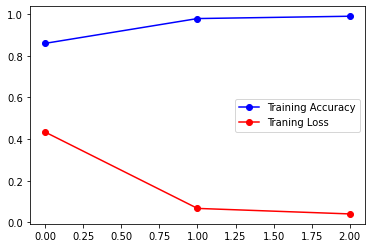

In [17]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc,'-ob',label = 'Training Accuracy')
#plt.figure()
plt.plot(loss,'-or', label = 'Traning Loss')

plt.legend();


### Predições com imagens retirada do google

In [18]:
def predicoes(path):
    # Abrir IMG
    sample_image = tf.keras.preprocessing.image.load_img(r'./some_img_for_test/'+str(path),
                                                    target_size=(224,224))
    plt.imshow(sample_image)
    # Img to Array
    sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
    # Colocar no formado (1,224,224,3)
    sample_image = np.expand_dims(sample_image,axis=0)
    # Normalizar de acordo com o Resnet50
    sample_image = tf.keras.applications.efficientnet.preprocess_input(sample_image)
    # prever
    predictions = model.predict(sample_image)
    
    #return predictions
    
    saida = {
        'birds':   predictions[0][0],
        'cats':    predictions[0][1],
        'dogs':    predictions[0][2],
        'fishs':   predictions[0][3],
        'hamsters':predictions[0][4],
        'monkeys': predictions[0][5],
        'reptiles':predictions[0][6],
    }
    return saida

{'birds': 0.99994683,
 'cats': 3.3935873e-08,
 'dogs': 1.6670888e-06,
 'fishs': 2.695165e-05,
 'hamsters': 5.462638e-07,
 'monkeys': 2.8194088e-07,
 'reptiles': 2.3752606e-05}

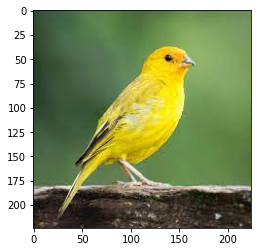

In [19]:
predicoes('canario.jpg')

{'birds': 0.00067722483,
 'cats': 7.1271876e-05,
 'dogs': 0.000805047,
 'fishs': 0.74259603,
 'hamsters': 4.2661188e-05,
 'monkeys': 0.000185937,
 'reptiles': 0.25562197}

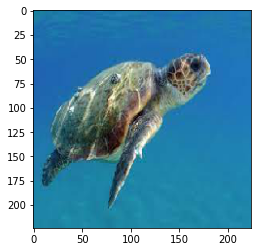

In [20]:
predicoes('tartaruga.jpg')

{'birds': 0.054695234,
 'cats': 0.00022807247,
 'dogs': 0.0070263967,
 'fishs': 0.002261867,
 'hamsters': 0.00050220446,
 'monkeys': 0.0022970294,
 'reptiles': 0.9329891}

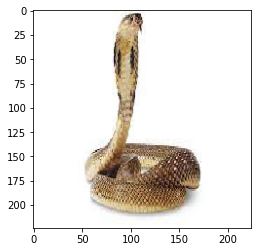

In [21]:
predicoes('cobra.jpg')

{'birds': 2.3059846e-07,
 'cats': 8.6533e-08,
 'dogs': 2.460327e-06,
 'fishs': 6.5890194e-06,
 'hamsters': 3.13559e-08,
 'monkeys': 0.9999801,
 'reptiles': 1.0517571e-05}

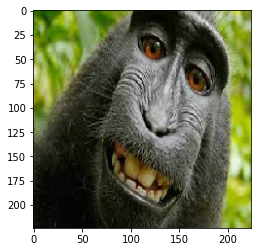

In [22]:
predicoes('macaco1.jpeg')

{'birds': 3.6543705e-07,
 'cats': 1.6807418e-07,
 'dogs': 8.076202e-06,
 'fishs': 4.4319717e-05,
 'hamsters': 2.9126372e-09,
 'monkeys': 0.99994123,
 'reptiles': 5.8580777e-06}

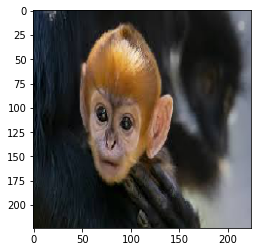

In [23]:
predicoes('macaco2.jpeg')

{'birds': 2.4061112e-11,
 'cats': 1.3627798e-11,
 'dogs': 8.3512275e-10,
 'fishs': 9.980323e-11,
 'hamsters': 1.0385651e-11,
 'monkeys': 1.0,
 'reptiles': 2.0043989e-09}

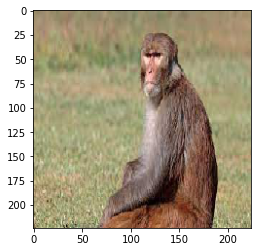

In [24]:
predicoes('macaco.jpeg')

{'birds': 0.99969244,
 'cats': 5.9442485e-08,
 'dogs': 1.1242994e-06,
 'fishs': 0.0002664636,
 'hamsters': 6.642527e-07,
 'monkeys': 4.2963762e-07,
 'reptiles': 3.8907183e-05}

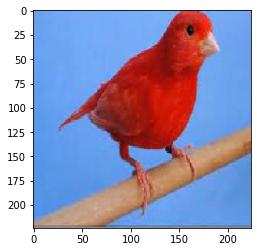

In [25]:
predicoes('canario1.jpg')

{'birds': 0.99997497,
 'cats': 2.2643526e-08,
 'dogs': 3.5419607e-06,
 'fishs': 1.0635305e-05,
 'hamsters': 1.1646023e-06,
 'monkeys': 4.733869e-07,
 'reptiles': 9.18338e-06}

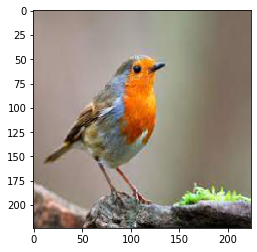

In [26]:
predicoes('birds.2.jpg')

{'birds': 5.0242546e-05,
 'cats': 1.1811593e-07,
 'dogs': 0.99930584,
 'fishs': 8.027671e-07,
 'hamsters': 4.2906908e-07,
 'monkeys': 0.0005548531,
 'reptiles': 8.7605586e-05}

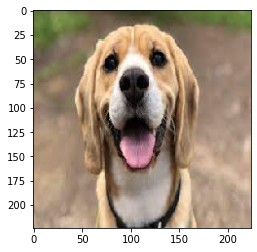

In [27]:
predicoes('dog99.jpeg')

{'birds': 5.75819e-07,
 'cats': 2.1754364e-08,
 'dogs': 7.835902e-06,
 'fishs': 3.106394e-05,
 'hamsters': 5.4040905e-09,
 'monkeys': 2.2232864e-06,
 'reptiles': 0.9999583}

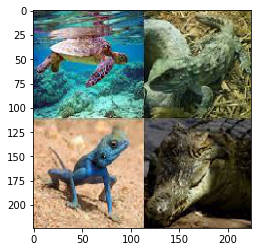

In [28]:
predicoes('reptiles.0.jpg')

{'birds': 9.122032e-06,
 'cats': 0.99988496,
 'dogs': 8.305321e-05,
 'fishs': 2.3813905e-06,
 'hamsters': 1.2787269e-06,
 'monkeys': 1.3449153e-07,
 'reptiles': 1.8996776e-05}

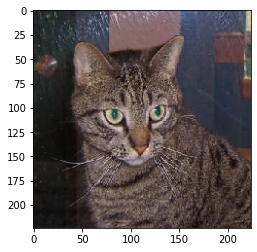

In [29]:
predicoes('cat.1.jpg')

{'birds': 8.430776e-07,
 'cats': 2.2115572e-07,
 'dogs': 0.9999802,
 'fishs': 1.2034991e-06,
 'hamsters': 3.0975585e-08,
 'monkeys': 1.1402794e-06,
 'reptiles': 1.6289205e-05}

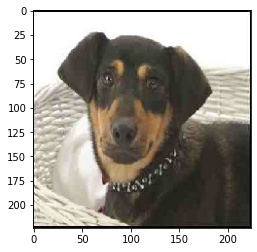

In [30]:
predicoes('dog.jpg')

{'birds': 2.1334073e-07,
 'cats': 0.9999677,
 'dogs': 3.1710042e-05,
 'fishs': 8.309243e-08,
 'hamsters': 3.3324017e-08,
 'monkeys': 1.1387751e-08,
 'reptiles': 2.3003967e-07}

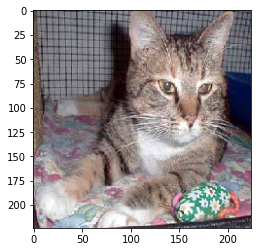

In [31]:
predicoes('gato.jpg')

{'birds': 0.0072052795,
 'cats': 0.0003195819,
 'dogs': 0.29050013,
 'fishs': 0.006955083,
 'hamsters': 0.0015032826,
 'monkeys': 0.21694236,
 'reptiles': 0.47657433}

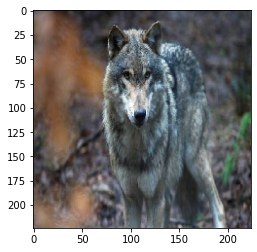

In [32]:
predicoes('lobo.jpg') # ele reconheceu 79% cachorro

{'birds': 4.396013e-05,
 'cats': 6.541731e-05,
 'dogs': 0.7407256,
 'fishs': 4.5849483e-05,
 'hamsters': 3.8870006e-05,
 'monkeys': 0.23897077,
 'reptiles': 0.020109605}

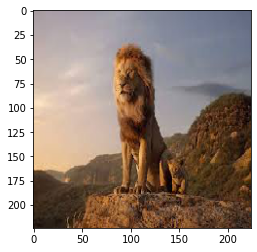

In [33]:
predicoes('leao.jpg') # Entendeu 99% cachorro

{'birds': 0.0012199947,
 'cats': 0.043714855,
 'dogs': 0.39901417,
 'fishs': 0.0032941932,
 'hamsters': 0.0054373606,
 'monkeys': 0.1307267,
 'reptiles': 0.4165927}

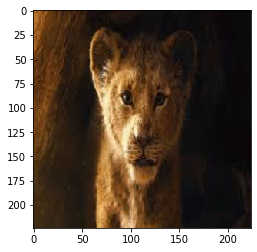

In [34]:
predicoes('filhote_leao.jpg') # Entendeu 63% gato

{'birds': 0.0599566,
 'cats': 0.0045903036,
 'dogs': 0.003303673,
 'fishs': 0.26397783,
 'hamsters': 0.010172808,
 'monkeys': 0.64718413,
 'reptiles': 0.010814629}

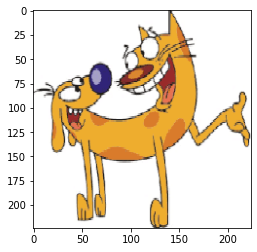

In [35]:
predicoes('catdog.png')

{'birds': 0.0015003235,
 'cats': 0.00085119245,
 'dogs': 0.00287149,
 'fishs': 0.34263074,
 'hamsters': 0.00017823935,
 'monkeys': 0.00086378586,
 'reptiles': 0.6511042}

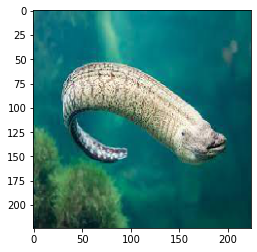

In [36]:
predicoes('moreia.jpeg')

{'birds': 4.4975036e-06,
 'cats': 2.137021e-07,
 'dogs': 1.7375042e-06,
 'fishs': 0.99984336,
 'hamsters': 1.1577023e-06,
 'monkeys': 8.0392306e-07,
 'reptiles': 0.00014813014}

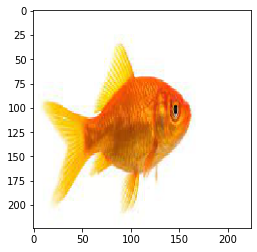

In [37]:
predicoes('fish.jpeg')

{'birds': 0.009554331,
 'cats': 0.0100010075,
 'dogs': 0.07915849,
 'fishs': 0.38212943,
 'hamsters': 0.0021932798,
 'monkeys': 0.36534315,
 'reptiles': 0.15162033}

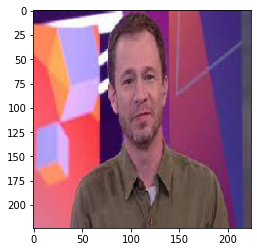

In [38]:
predicoes('homem2.jpeg')

In [39]:
# Save
model.save('./model_EfficientNetB0.h5')

### Arquivos para o FLASK

In [40]:
import tensorflow as tf

# LOAD
model = tf.keras.models.load_model('./model_EfficientNetB0.h5')

def predicoes(path):
    # Abrir IMG
    sample_image = tf.keras.preprocessing.image.load_img(r'./some_img_for_test/'+str(path),
                                                    target_size=(224,224))
    plt.imshow(sample_image)
    # Img to Array
    sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
    # Colocar no formado (1,224,224,3)
    sample_image = np.expand_dims(sample_image,axis=0)
    # Normalizar de acordo com o Resnet50
    sample_image = tf.keras.applications.efficientnet.preprocess_input(sample_image)
    # prever
    predictions = model.predict(sample_image)
    
    #return predictions
    
    saida = {
        'birds':   predictions[0][0],
        'cats':    predictions[0][1],
        'dogs':    predictions[0][2],
        'fishs':   predictions[0][3],
        'hamsters':predictions[0][4],
        'monkeys': predictions[0][5],
        'reptiles':predictions[0][6],
    }
    return saida

{'birds': 7.084907e-05,
 'cats': 6.916203e-06,
 'dogs': 7.116127e-06,
 'fishs': 5.8228798e-05,
 'hamsters': 2.0073806e-07,
 'monkeys': 6.792387e-06,
 'reptiles': 0.9998499}

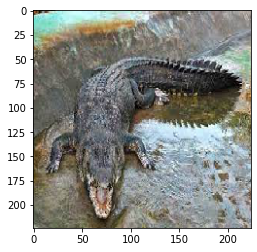

In [41]:
predicoes('croc.jpeg')

{'birds': 1.8260732e-07,
 'cats': 0.99993944,
 'dogs': 5.996384e-05,
 'fishs': 1.5439257e-08,
 'hamsters': 2.3161658e-07,
 'monkeys': 6.99699e-09,
 'reptiles': 7.16571e-08}

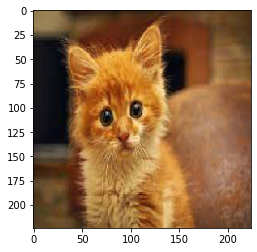

In [42]:
predicoes('gatinho.jpeg')

{'birds': 9.122032e-06,
 'cats': 0.99988496,
 'dogs': 8.305321e-05,
 'fishs': 2.3813905e-06,
 'hamsters': 1.2787269e-06,
 'monkeys': 1.3449153e-07,
 'reptiles': 1.8996776e-05}

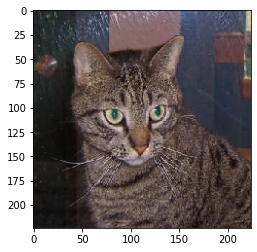

In [43]:
predicoes('cat.1.jpg')